In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from bs4 import BeautifulSoup

excel = pd.ExcelFile('jester-data-1.xls')
data = excel.parse(excel.sheet_names[0], header=None)
data = data.loc[:,1:] # Number of ratings dropped

# Dane
Zanim przejdę do realizacji listy, opiszę po krótce dane. Każdy rząd reprezentuje użytkownika, każda kolumna reprezentuje żart, wartość danego rekordu to ocena żart w przedziale od -10 do 10. Występują również wartości 99, które zastępują NaN.

In [2]:
data

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,4.90,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,99.00,99.00,99.00,99.00,-7.77,99.00,6.70,-6.75,99.00,99.00,...,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00
24981,99.00,99.00,99.00,99.00,-9.71,99.00,4.56,-8.30,99.00,99.00,...,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00


# Ekstracja cech

Przetworzenie plików html w celu uzyskania żartów.

In [3]:
import os

def extract_text_from_html(html):
    html_content = ''
    with open(html, 'r', encoding='utf-8', errors='replace') as f:
        html_content = f.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup.get_text()

html_dir = 'jokes/'

jokes_text = []
jokes_id = []

for file in os.listdir(html_dir):
    file_path = os.path.join(html_dir, file)
    joke_text = extract_text_from_html(file_path)
    joke_id = int(file[len('init'):-len('.html')])
    jokes_id.append(joke_id)                  
    jokes_text.append(joke_text)

jokes_text = [text.replace('\n', '') for text in jokes_text]

jokes_text_df = pd.DataFrame({'joke_id': jokes_id, 'joke_text': jokes_text})

Właściwa ekstrakcja cech.

In [4]:
import fasttext.util
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2') # No sentence-transformers model found with name bert-base-cased

model2 = fasttext.load_model('cc.en.300.bin')

joke_embeddings = model.encode(jokes_text_df['joke_text'].tolist())
joke_embeddings2 = np.array([model2.get_sentence_vector(text) for text in jokes_text_df['joke_text'].tolist()])

/home/rafal/Documents/SI4/venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/home/rafal/Documents/SI4/venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
num_cols1 = len(joke_embeddings[0])
num_cols2 = len(joke_embeddings2[0])
column_names1 = [f'sentence_{x+1}' for x in range(num_cols1)]
column_names2 = [f'fasttext_{x+1}' for x in range(num_cols2)]
embedding_df1 = pd.DataFrame(joke_embeddings, columns=column_names1)
embedding_df2 = pd.DataFrame(joke_embeddings2, columns=column_names2)
embedding_df1['joke_id'] = jokes_text_df['joke_id']
embedding_df2['joke_id'] = jokes_text_df['joke_id']

embedding_df = pd.merge(embedding_df1, embedding_df2, on='joke_id')

In [6]:
embedding_df.head()

,sentence_1,sentence_2,sentence_3,sentence_4,sentence_5,sentence_6,sentence_7,sentence_8,sentence_9,sentence_10,...,fasttext_291,fasttext_292,fasttext_293,fasttext_294,fasttext_295,fasttext_296,fasttext_297,fasttext_298,fasttext_299,fasttext_300
0,-0.095922,0.062821,-0.011296,0.085958,-0.052748,-0.036287,0.092505,-0.053177,0.038225,-0.049709,...,0.042943,-0.003803,-0.052063,0.014772,0.006764,-0.001297,-0.000282,0.103713,0.009030,0.000449
1,-0.020733,-0.028696,0.008222,0.009164,-0.043350,0.028239,-0.006265,0.029038,0.026844,-0.031654,...,0.032375,0.011371,-0.028806,-0.014579,-0.004268,-0.011612,0.005870,0.064978,0.014601,0.007099
2,-0.097867,-0.033695,0.025453,0.034710,-0.015377,-0.060813,0.058097,0.011138,0.024452,-0.000101,...,0.027842,-0.002289,-0.060731,-0.006170,-0.006167,0.025174,0.007917,0.103881,0.004929,0.000202
3,-0.042858,0.026852,-0.002035,0.005390,-0.061815,-0.069393,0.104375,-0.009937,-0.053553,-0.035253,...,0.028317,-0.008254,-0.065190,0.008700,0.005998,-0.005823,0.012264,0.086648,-0.003556,0.000752
4,-0.037442,0.001878,0.041570,0.013374,0.056332,-0.099929,0.126229,0.000877,0.009933,0.034413,...,0.010729,-0.007358,-0.048880,0.000692,-0.002981,-0.010506,0.005906,0.090833,0.015138,0.001338


Połączenie cech z odpowiadającymi im żartami oraz wyznacznie X (cech) i Y (etykiet).

In [35]:
new_data = data.T

indecies = list(range(1, new_data.shape[0] + 1))

new_data['joke_id'] = indecies

merged_df = pd.merge(new_data, embedding_df, on='joke_id')
merged_df = merged_df.drop(columns='joke_id')
# embedding_df = embedding_df.drop(columns='joke_id')
# new_data = new_data.drop(columns='joke_id')

# merged_df.replace(99, np.nan, inplace=True)

X = merged_df[embedding_df.drop(columns='joke_id').columns.tolist()]
Y = merged_df.drop(columns=X.columns.tolist())

def replace_99_with_avg(row):
    non_99_values = row[row != 99 ]
    if len(non_99_values) == 0:
        return row
    avg = non_99_values.mean()
    return row.apply(lambda x: avg if x == 99 else x)

Y = Y.apply(replace_99_with_avg, axis=1)
Y['target_rating'] = Y.apply(lambda row: row[row != 99].mean(), axis=1)
Y = Y[['target_rating']].values.ravel() # Taking only avg of ratings

# Trenowanie sieci

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

mlp = MLPRegressor(solver='sgd',alpha=0.0,learning_rate='constant',warm_start=True,max_iter=1,random_state=42) # Warm start for incremental learning

EPOCHS = 2000

train_errors = []
test_errors = []

for _ in range(EPOCHS):
    mlp.partial_fit(X_train, Y_train)
    train_errors.append(mean_squared_error(Y_train, mlp.predict(X_train)))
    test_errors.append(mean_squared_error(Y_test, mlp.predict(X_test)))
    
# history = mlp.fit(X_train, Y_train)

# Y_pred = mlp.predict(X_test)

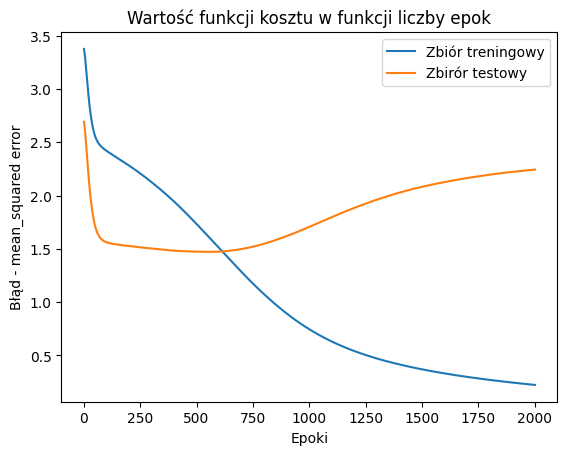

In [48]:
plt.plot(range(1, EPOCHS+1), train_errors, label='Zbiór treningowy')
plt.plot(range(1, EPOCHS+1), test_errors, label='Zbirór testowy')
plt.title('Wartość funkcji kosztu w funkcji liczby epok')
plt.xlabel('Epoki')
plt.ylabel('Błąd - mean_squared_error')
plt.legend()
plt.show()

Jak można zauważyć przez pierwsze ~100 epok model szybko się uczy, tj. błąd bardzo szybko spada. Następnie przez około 500 epok (do ~600) błąd minimalnie spada, czyli nie widać znacznej poprawy w nauce sieci neuronowej. Na koniec począwszy od ~600 epoki zauważalne jest zjawisko overfittingu. Model praktycznie nauczył się "na pamięć" danych treningowych, zamiast generalizować i skutecznie radzić sobie z przewidywaniem. Dane treningowe nie zmieniają się, więc błąd dla nich stale maleje.

# Zadanie 3

Parametr learning_rate MLPRegressor ma 3 możliwe wartości, tj. constant, invscaling, adaptive. Dodatkowo jest zmienna learning_rate_init, której większe wartości reprezentują szybsze uczenie.

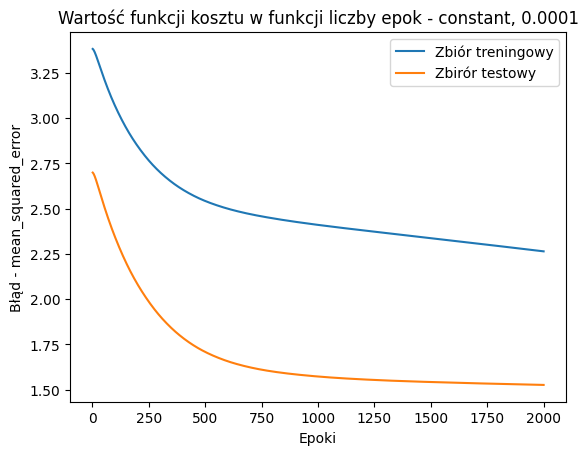

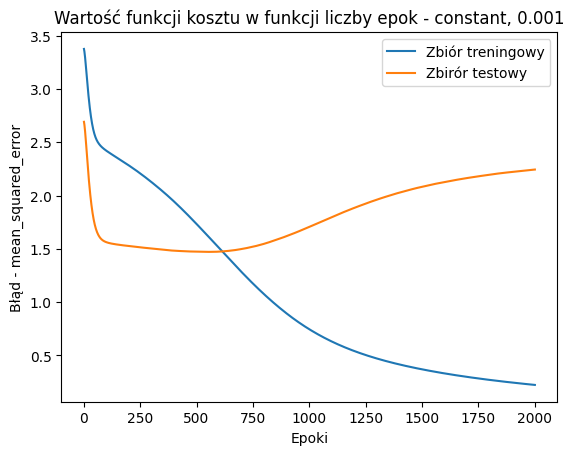

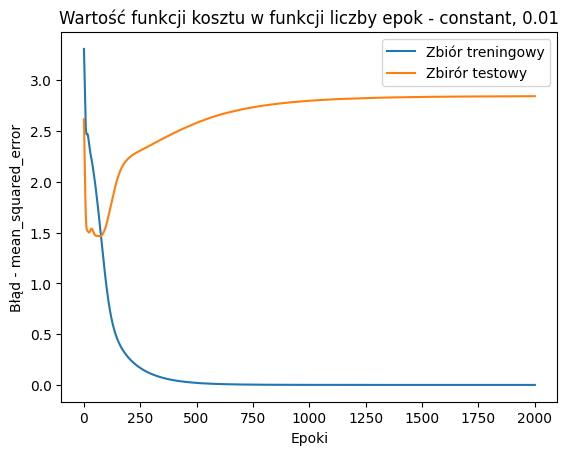

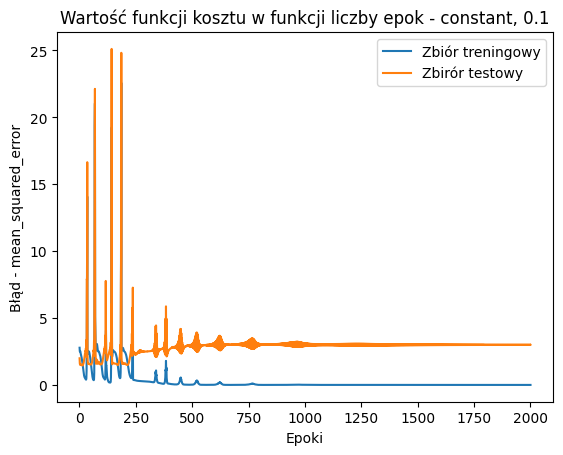

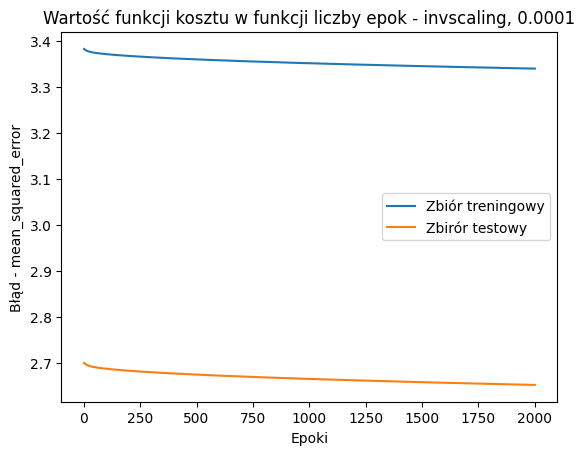

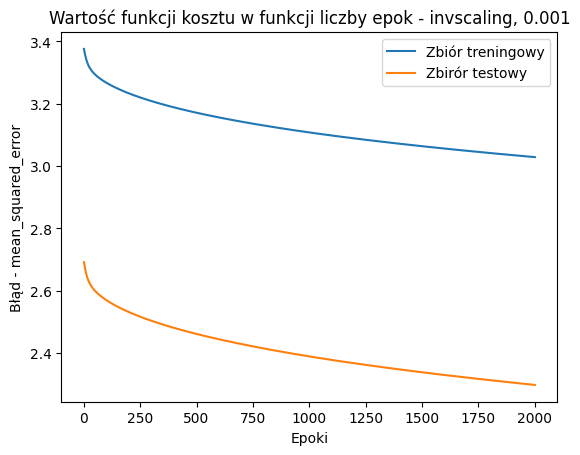

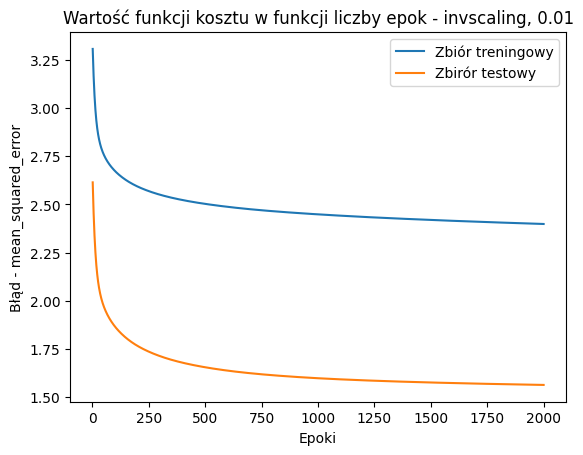

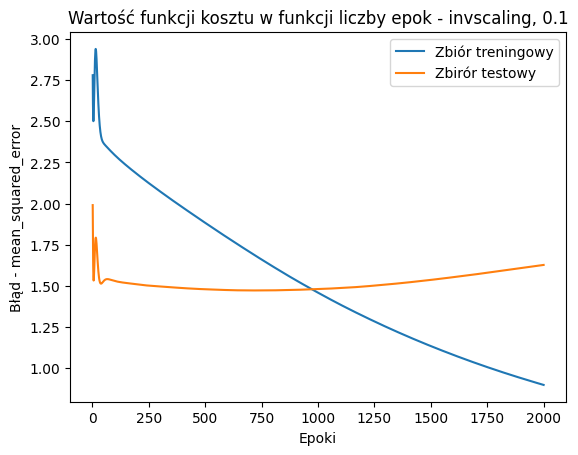

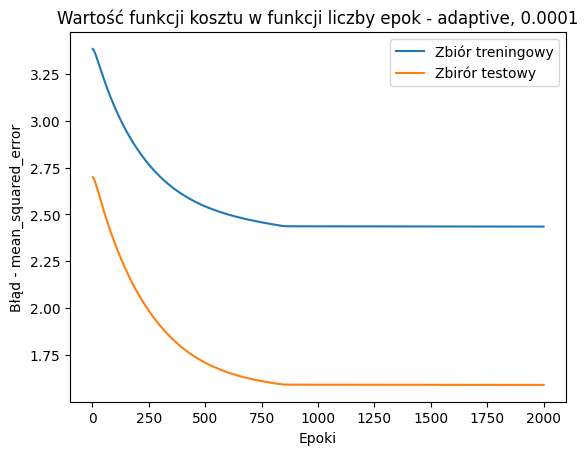

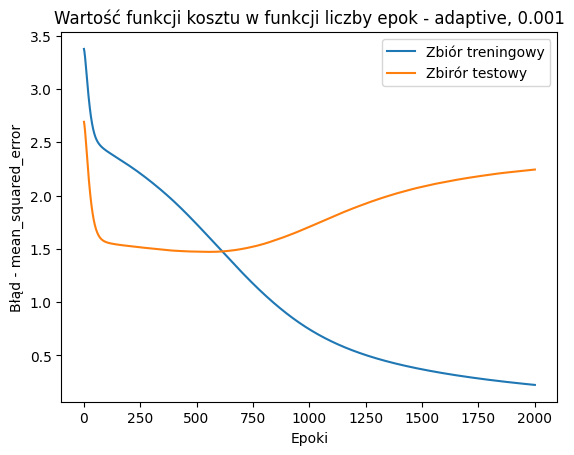

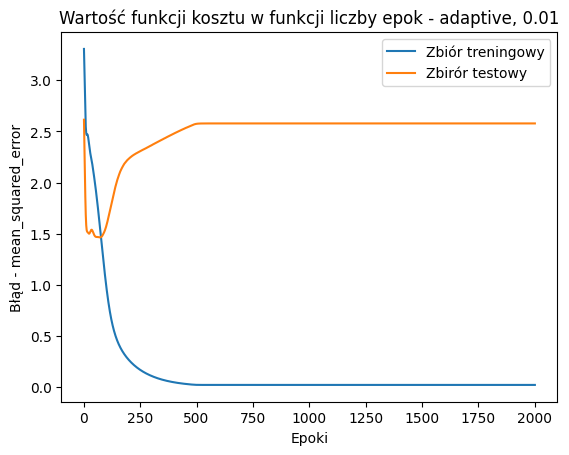

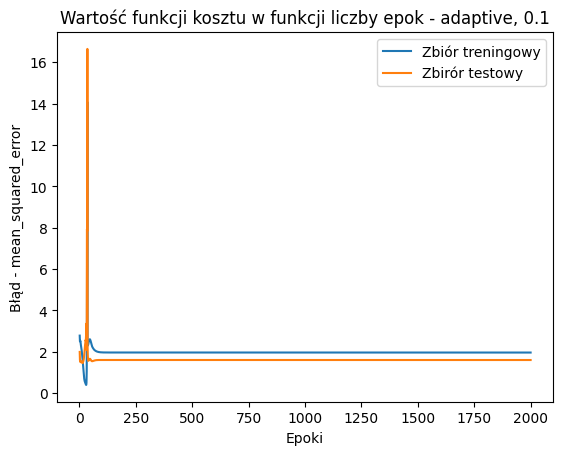

In [51]:
from itertools import product

def learning_rate(learning_rate, learning_rate_init, epochs):
    mlp = MLPRegressor(solver='sgd',alpha=0.0,learning_rate=learning_rate,learning_rate_init=learning_rate_init,warm_start=True,max_iter=1,random_state=42) # Warm start for incremental learning
    
    train_errors = []
    test_errors = []
    
    for _ in range(epochs):
        mlp.partial_fit(X_train, Y_train)
        train_errors.append(mean_squared_error(Y_train, mlp.predict(X_train)))
        test_errors.append(mean_squared_error(Y_test, mlp.predict(X_test)))
        
    plt.plot(range(1, epochs+1), train_errors, label='Zbiór treningowy')
    plt.plot(range(1, epochs+1), test_errors, label='Zbirór testowy')
    plt.title(f'Wartość funkcji kosztu w funkcji liczby epok - {learning_rate}, {learning_rate_init}')
    plt.xlabel('Epoki')
    plt.ylabel('Błąd - mean_squared_error')
    plt.legend()
    plt.show()

l1 = ['constant','invscaling','adaptive']
l2 = [1e-4,1e-3,1e-2,1e-1]

combination = list(product(l1,l2))

for c in combination:
    rate = c[0]
    init = c[1]
    learning_rate(rate, init, 2000)

Jak można zauważyć różnicy między adaptive i constant nie są bardzo widoczne. Największą zmianę widać dla tych learning_rate przy użyciu learning_rate_init=0.1, gdzie adaptive o wiele skuteczniej radzi sobie z overfittingiem. Najlepiej wypada invscaling, który bez względu na learning_rate_init nie pozwala na overfitting, ale dla zmniejszych wartości learning_rate_init potrzebuje o wiele więcej epok, żeby osiągnąć podobny próg błędu jak pozostałe metody. Najlepiej wydał moim zdaniem model dla parametrów (adaptive,0.01), ponieważ pozwala osiągnąć bardzo dobrą wartość błędu dla zbioru testowego przy zachowaniu małej liczby epok.

# Zadanie 4
Zmienna hidden_layer_sizes pozwala ustawić wielowarstwowość modelu oraz liczbę neuronów na poszczególnej warstwie. Dodatkowa ukryta warstwa pozwala na zwiększenie złożności obliczeniowej na wejściowych danych i w teorii pozwala modelowi na lepsze uczenie się.

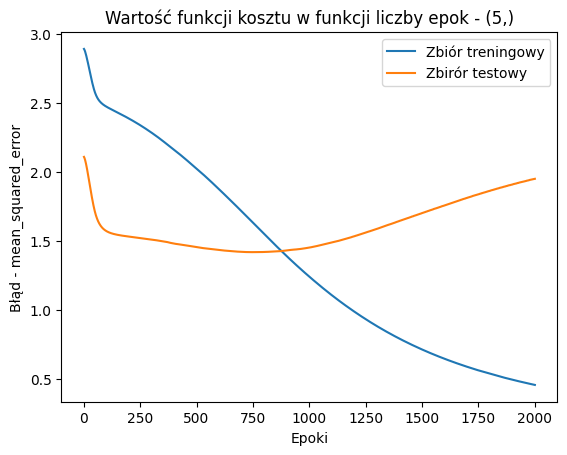

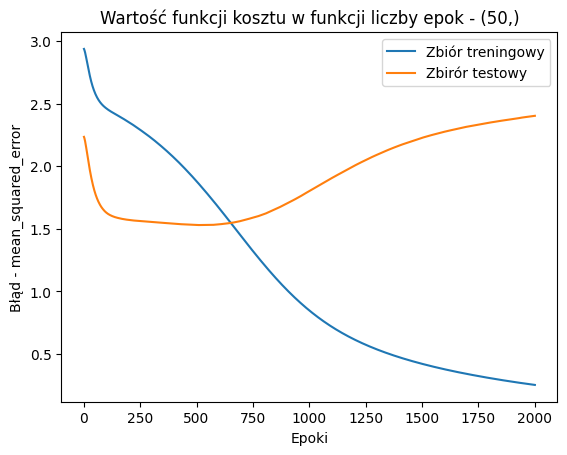

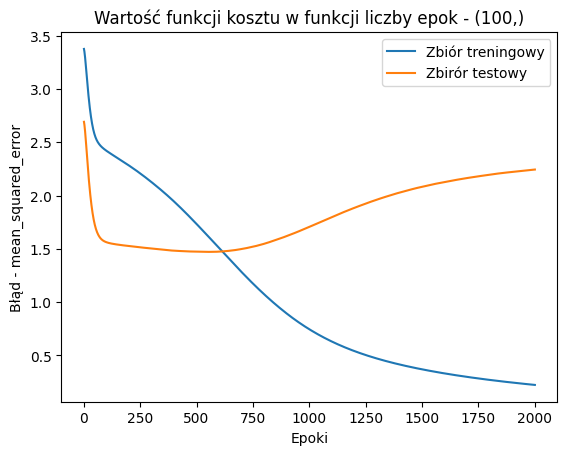

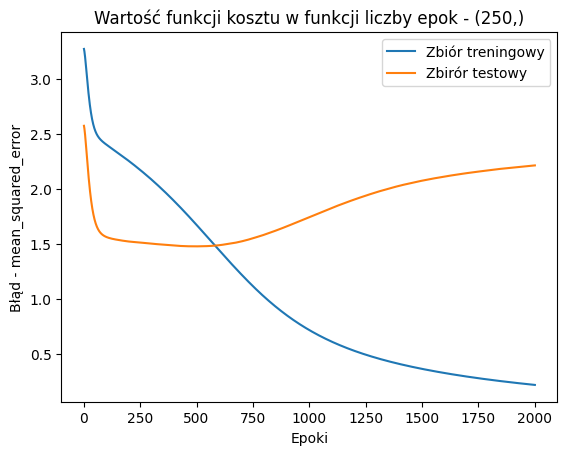

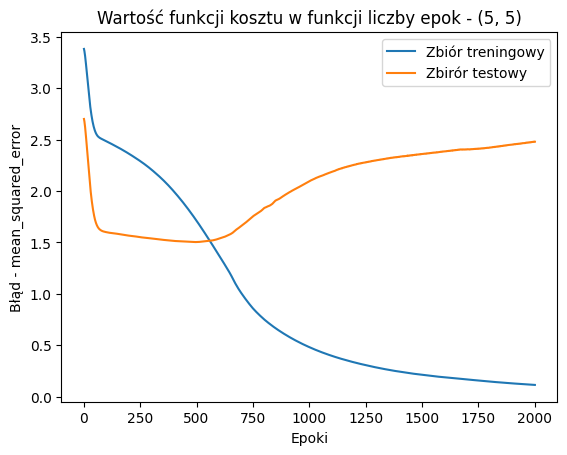

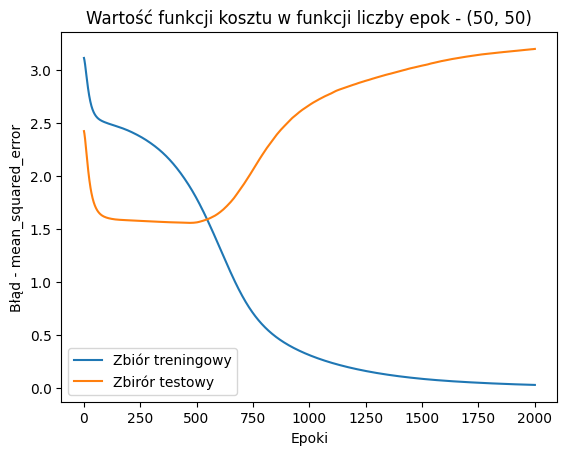

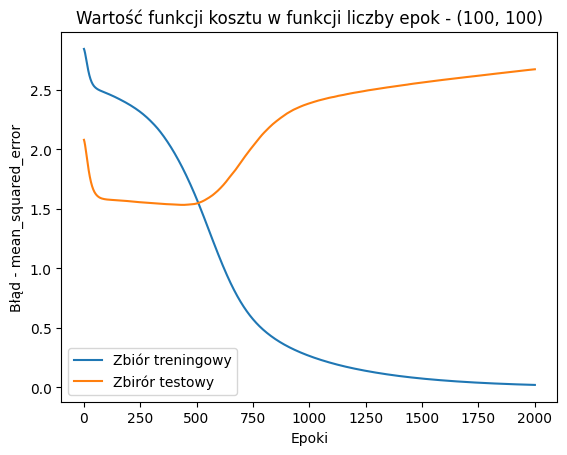

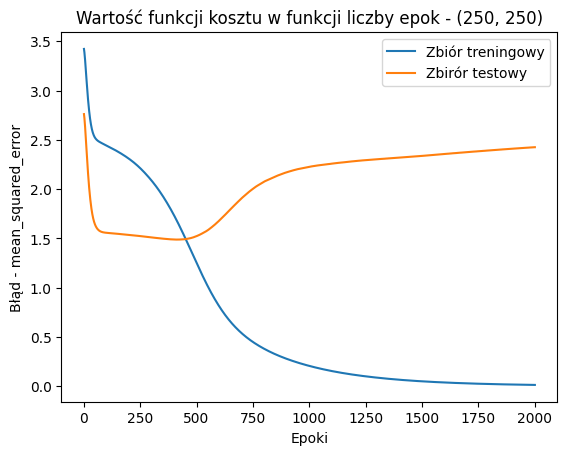

In [100]:
def learning_rate(neurons, epochs):
    mlp = MLPRegressor(hidden_layer_sizes=neurons,solver='sgd',alpha=0.0,learning_rate='constant',warm_start=True,max_iter=1,random_state=42) # Warm start for incremental learning
    
    train_errors = []
    test_errors = []
    
    for _ in range(epochs):
        mlp.partial_fit(X_train, Y_train)
        train_errors.append(mean_squared_error(Y_train, mlp.predict(X_train)))
        test_errors.append(mean_squared_error(Y_test, mlp.predict(X_test)))
        
    plt.plot(range(1, epochs+1), train_errors, label='Zbiór treningowy')
    plt.plot(range(1, epochs+1), test_errors, label='Zbirór testowy')
    plt.title(f'Wartość funkcji kosztu w funkcji liczby epok - {neurons}')
    plt.xlabel('Epoki')
    plt.ylabel('Błąd - mean_squared_error')
    plt.legend()
    plt.show()

l1 = [(5,),(50,),(100,),(250,),(5,5),(50,50),(100,100),(250,250)]

for n in l1:
    learning_rate(n, 2000)

Jak można zauważyć druga (ukryta warstwa) znacząco zwiększa moc obliczeniową modelu. Można to zauważyć patrząc się na początek i koniec zakresu epok. Modele z mniejszą ilością neuronów radzą sobie zdecydowanie gorzej na początku, ale o wiele szybciej zmniejszają poziom błędu do standardowego (w okolicach 1.5). Poza tym overfittingu jest wyraźnie mniejsze wraz z epokami. Można założyć, że dla danych treningowych/tesotowych o wiele większym stopniu skomplikowania i wymagające większej ilości epok, efekt byłby bardziej zauważalny. Dla danych wykorzystywanych tutaj jednowymiarowe 5 neuronów zasadniczo nie różni się od dwuwymiarowych 250 neuronów.

# Zadanie 5

Na podstawie wcześniejszych zadań na liście wybrałem poniższą konfigurację MLPRegressor w celu uzyskania najkorzystniejszych wyników.

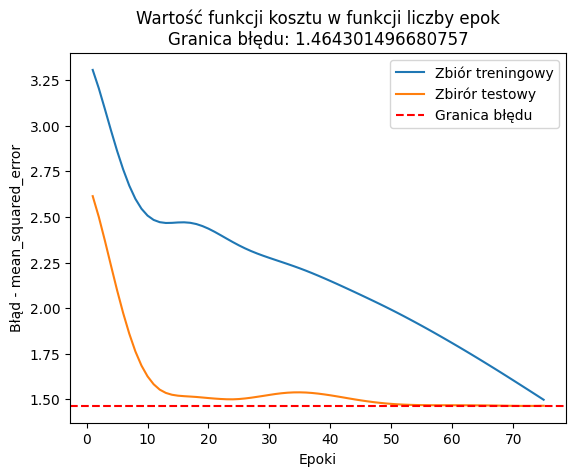

In [69]:
mlp = MLPRegressor(solver='sgd',alpha=0.0,learning_rate='adaptive',learning_rate_init=0.01,warm_start=True,max_iter=1,random_state=42) # Warm start for incremental learning
    
train_errors = []
test_errors = []

epochs = 75

for _ in range(epochs):
    mlp.partial_fit(X_train, Y_train)
    train_errors.append(mean_squared_error(Y_train, mlp.predict(X_train)))
    test_errors.append(mean_squared_error(Y_test, mlp.predict(X_test)))

error = mean_squared_error(Y_test, mlp.predict(X_test))
    
plt.plot(range(1, epochs+1), train_errors, label='Zbiór treningowy')
plt.plot(range(1, epochs+1), test_errors, label='Zbirór testowy')
plt.axhline(error, color='r', linestyle='--', label='Granica błędu')
plt.title(f'Wartość funkcji kosztu w funkcji liczby epok\nGranica błędu: {error}')
plt.xlabel('Epoki')
plt.ylabel('Błąd - mean_squared_error')
plt.legend()
plt.show()

Subiektywnie najlepiej wyszkolonej sieci przekazuję listę żartów zdefiniowaną przez ChatGPT. 

In [94]:
jokes = [
    "Why don't scientists trust atoms? Because they make up everything!",
    "I used to play piano by ear, but now I use my hands like everyone else.",
    "I told my wife she should embrace her mistakes. She gave me a hug.",
    "Parallel lines have so much in common. It’s a shame they’ll never meet.",
    "What do you call fake spaghetti? An impasta!",
    "I'm reading a book on anti-gravity. It's impossible to put down!",
    "I asked God for a bike, but I know God doesn't work that way. So, I stole a bike and asked for forgiveness.",
    "I told my wife she should embrace her mistakes. She gave me a hug.",
    "I’m on a whiskey diet. I’ve lost three days already.",
    "I knew I shouldn't steal a mixer from work, but it was a whisk I was willing to take."
]

own_embeddings1 = model.encode(jokes)
own_embeddings2 = np.array([model2.get_sentence_vector(text) for text in jokes])
own_embeddings = np.hstack((own_embeddings1, own_embeddings2))

mlp = MLPRegressor(solver='sgd',alpha=0.0,learning_rate='adaptive',learning_rate_init=0.01,warm_start=True,max_iter=1,random_state=42) # Warm start for incremental learning

for _ in range(75):
    mlp.partial_fit(X_train, Y_train)

ratings = mlp.predict(own_embeddings)

for i in range(10):
    joke = jokes[i]
    rating = ratings[i]
    print(f'Joke: {joke}')
    print(f'Neural Network rating: {rating:.2f}')

Joke: Why don't scientists trust atoms? Because they make up everything!
Neural Network rating: 0.62
Joke: I used to play piano by ear, but now I use my hands like everyone else.
Neural Network rating: 0.54
Joke: I told my wife she should embrace her mistakes. She gave me a hug.
Neural Network rating: 1.14
Joke: Parallel lines have so much in common. It’s a shame they’ll never meet.
Neural Network rating: 0.72
Joke: What do you call fake spaghetti? An impasta!
Neural Network rating: 0.39
Joke: I'm reading a book on anti-gravity. It's impossible to put down!
Neural Network rating: 0.70
Joke: I asked God for a bike, but I know God doesn't work that way. So, I stole a bike and asked for forgiveness.
Neural Network rating: 0.44
Joke: I told my wife she should embrace her mistakes. She gave me a hug.
Neural Network rating: 1.14
Joke: I’m on a whiskey diet. I’ve lost three days already.
Neural Network rating: 0.49
Joke: I knew I shouldn't steal a mixer from work, but it was a whisk I was wil

/home/rafal/Documents/SI4/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Można zauważyć, że długość żartów ma znaczenie. Najlepiej oceniony żart 1.14 ma podobną długość do żartów ocenianych 0.62, 0.54, 0.70, 0.77. Można się sugerowac natomiast, że krótsze i najdłuższe żarty są gorsze - dwa najkrótsze żarty mają najsłabsze oceny, tj. 0.39 i 0.49 dla krótkich oraz 0.44 dla długiego. Względem długości najlepiej oceniane są żarty średniej długości, ale nie jest to również reguła (jeden ma 0.54). Trudno zauważyć inne zależności, ale trzy żarty z zakresu >0.70 mają sformułowanie ...it's/it is..., co może sugerować, że żarty na zasadzie *kontekst*, it's *puenta* są śmieszniejsze.

# Zadanie 6

Za dodatkowy parametr do zbadania wybrałem regularyzację. Służy ona do zapobiegania overfittingowi oraz ogólnie lepszej generalizacji modelu, dzięki czemu lepiej radzi sobie z nieprzetrenowanymi zbiorami danych.

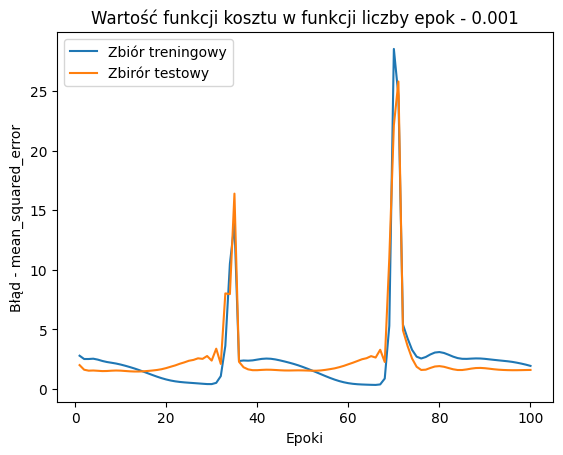

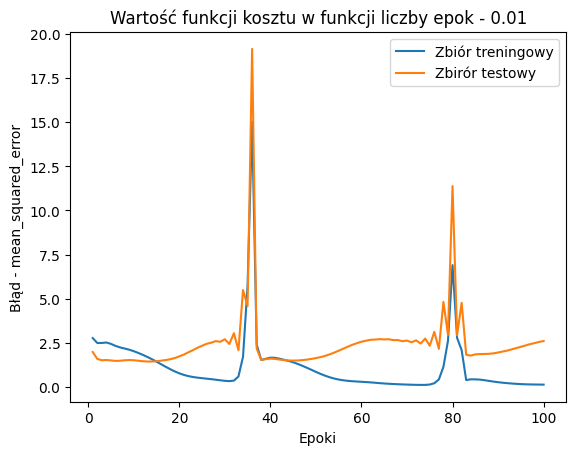

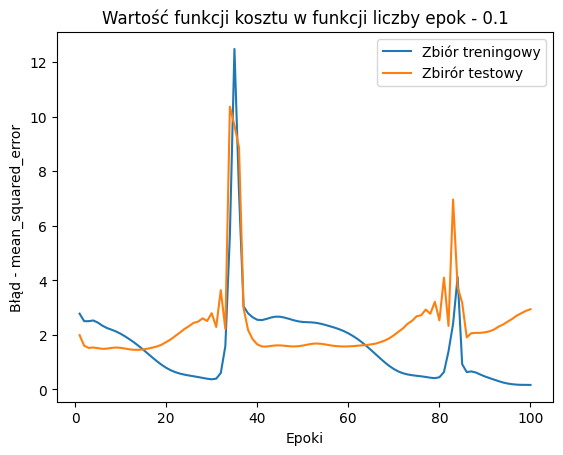

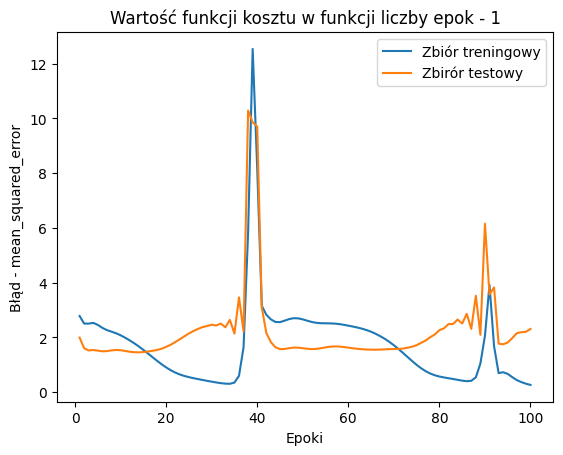

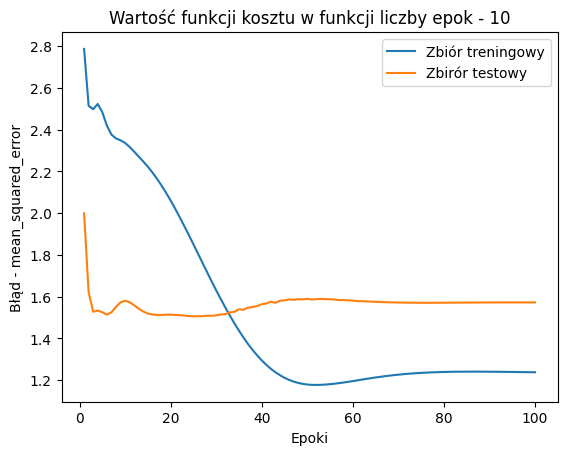

In [99]:
def learning_rate(alpha, epochs):
    mlp = MLPRegressor(solver='sgd',alpha=alpha,learning_rate='constant',learning_rate_init=0.1,warm_start=True,max_iter=1,random_state=42) # Warm start for incremental learning
    
    train_errors = []
    test_errors = []
    
    for _ in range(epochs):
        mlp.partial_fit(X_train, Y_train)
        train_errors.append(mean_squared_error(Y_train, mlp.predict(X_train)))
        test_errors.append(mean_squared_error(Y_test, mlp.predict(X_test)))
        
    plt.plot(range(1, epochs+1), train_errors, label='Zbiór treningowy')
    plt.plot(range(1, epochs+1), test_errors, label='Zbirór testowy')
    plt.title(f'Wartość funkcji kosztu w funkcji liczby epok - {alpha}')
    plt.xlabel('Epoki')
    plt.ylabel('Błąd - mean_squared_error')
    plt.legend()
    plt.show()

l1 = [1e-3,1e-2,1e-1,1,10]

for a in l1:
    learning_rate(a, 100)

Jak można zauważyć na powyższych przykładach alpha odpowiadająca za regularyzację skutecznie zwalcza overfitting. Nawet dla skrajnie dużych szybkości uczenia (learning_rate_init=0.1) alpha skutecznie zapobiegała overfittingowi nawet w przedziale epok zmniejszym niż 100. Widać również duży skok w efektywności regularyzacji dla wartości większych niż 1 - dla alpha=10 overfitting praktycznie zniknął.